In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Importing Dataset

In [5]:
data = pd.read_csv("D:\POLTEKSSN/TINGKAT 3/Rekayasa Sosial/Chrome-Extension-Phishing/back-end/phishing.csv")
data = data.drop(['Index'], axis=1)

In [6]:
# Preprocessing
X = data.drop(["class"], axis=1)
y = data["class"]

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Convert target to 0/1
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

In [9]:
# Model Training
models = {
    "XGBoost": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

In [11]:
# Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc = metrics.roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': cm,
        'y_proba': y_proba
    }

In [12]:
# Train and Evaluate All Models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_test, y_test)

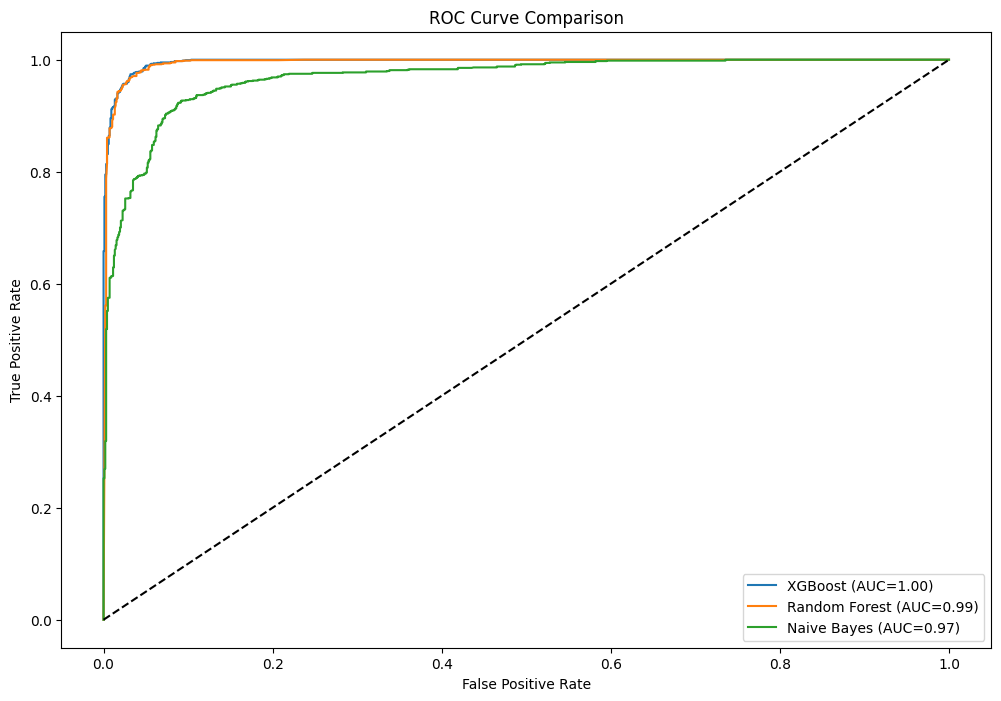

In [13]:
# Visual Comparison
## ROC Curve
plt.figure(figsize=(12, 8))
for name, res in results.items():
    if not np.isnan(res['ROC-AUC']):
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={res['ROC-AUC']:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

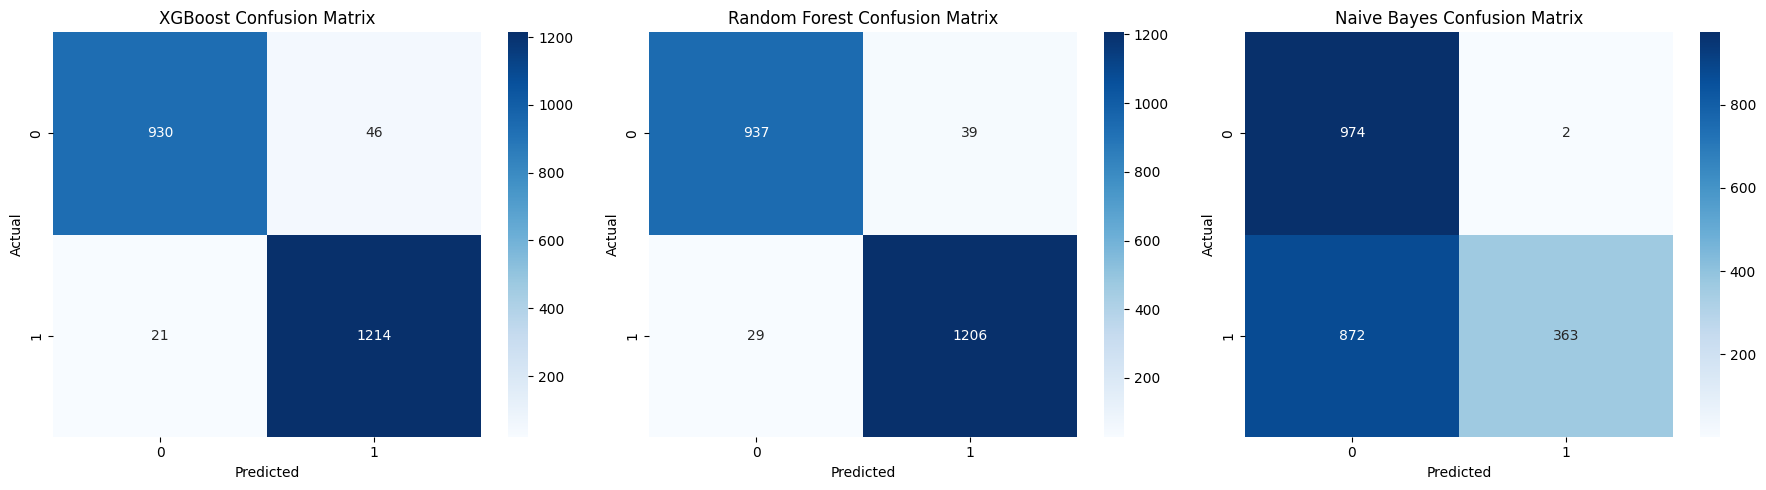

In [14]:
## Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for (name, res), ax in zip(results.items(), axes):
    sns.heatmap(res['Confusion Matrix'], annot=True, fmt='d', ax=ax, cmap='Blues')
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [15]:
## Performance Table
comparison_df = pd.DataFrame({
    model: {metric: score for metric, score in res.items() if metric not in ['Confusion Matrix', 'y_proba']}
    for model, res in results.items()
}).T.round(3)

print("Model Performance Comparison:")
display(comparison_df)

Model Performance Comparison:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
XGBoost,0.970,0.963,0.983,0.973,0.996
Random Forest,0.969,0.969,0.977,0.973,0.995
Naive Bayes,0.605,0.995,0.294,0.454,0.968


In [16]:
# Error Analysis
def analyze_errors(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = X_test[y_pred != y_test]
    error_labels = y_test[y_pred != y_test]
    return pd.concat([errors, error_labels], axis=1)

In [17]:
# Example for XGBoost
print("XGBoost Error Analysis Sample:")
display(analyze_errors(models["XGBoost"], X_test, y_test).head())

XGBoost Error Analysis Sample:


,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,Favicon,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
9215,1,-1,1,1,1,-1,1,1,-1,1,...,1,1,1,1,-1,-1,1,0,1,0
3078,1,-1,1,1,1,-1,0,-1,-1,1,...,1,1,-1,1,1,-1,1,0,-1,0
8765,1,-1,1,-1,1,-1,0,-1,-1,1,...,1,1,1,1,1,-1,1,0,1,0
2167,1,-1,1,1,1,-1,-1,1,-1,1,...,1,1,-1,1,0,-1,1,0,1,0
10238,1,1,1,1,1,-1,0,-1,-1,1,...,1,1,1,1,1,1,1,0,1,0


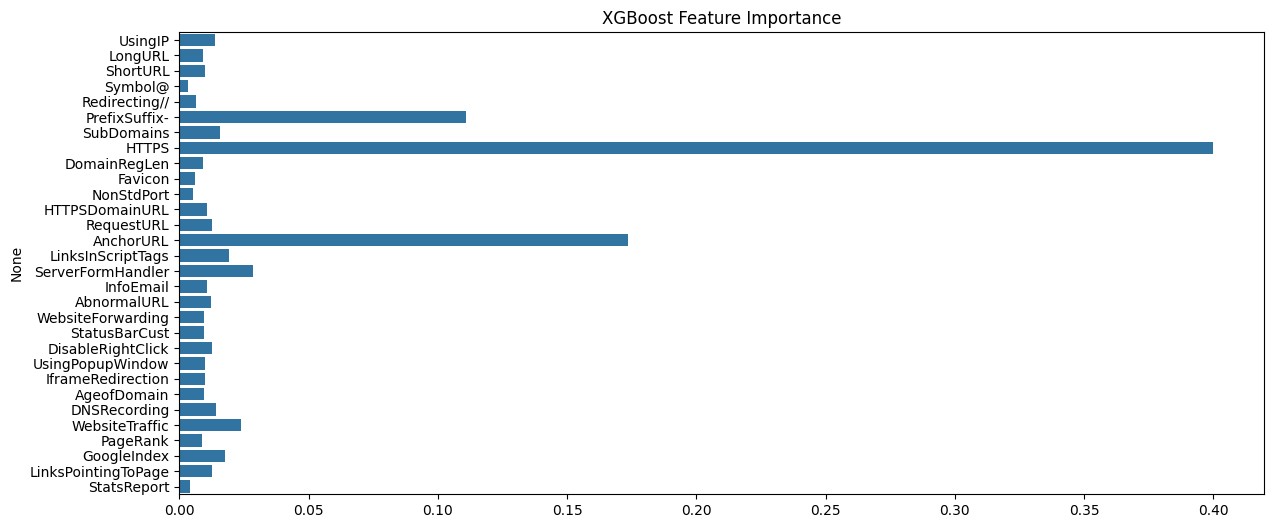

In [18]:
# Feature Importance
plt.figure(figsize=(14, 6))
sns.barplot(x=models["XGBoost"].feature_importances_, 
            y=X.columns)
plt.title('XGBoost Feature Importance')
plt.show()

In [19]:
# Save Models
import joblib
joblib.dump(models["XGBoost"], "xgboost_phishing.pkl")
joblib.dump(models["Random Forest"], "rf_phishing.pkl")
joblib.dump(models["Naive Bayes"], "nb_phishing.pkl")

['nb_phishing.pkl']

# Eksperimen Pembanding Model – Phishing URL

Eksperimen ini membandingkan Logistic Regression, SVM (Linear & RBF), Random Forest, XGBoost, dan (opsional) MLP pada dataset phishing.csv dengan:

- 5-fold Stratified CV
- Hyperparameter ringkas via GridSearchCV (inner 3-fold, scoring PR-AUC)
- Optimasi threshold untuk memaksimalkan F1 per-fold
- Metrik: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC
- Uji signifikansi: McNemar dan bootstrap 1.000× untuk CI 95% F1
- Analisis error & interpretabilitas: pola FP/FN, fitur paling berkontribusi, strategi mitigasi

In [ ]:
# Ensure extra packages for tests
import importlib, sys, subprocess

def ensure(pkg):
    try:
        importlib.import_module(pkg)
        return True
    except ImportError:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
        return True

ensure('statsmodels')

In [ ]:
# Imports & Data
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from scipy.stats import binom_test

np.random.seed(42)

# Load dataset
csv_path = Path('../back-end/phishing.csv') if not Path('phishing.csv').exists() else Path('phishing.csv')
df = pd.read_csv(csv_path)

# Target and features
y = (df['class'] == -1).astype(int).values  # 1 = phishing, 0 = legit
X = df.drop(columns=['class', 'Index'], errors='ignore')
feature_names = list(X.columns)
X = X.values.astype(float)

# Helpers

def find_best_threshold(y_true, prob, beta=1.0):
    # search threshold over unique scores for best F1
    order = np.argsort(prob)
    thresholds = np.unique(prob[order])
    best_t, best_f1 = 0.5, -1.0
    for t in thresholds:
        pred = (prob >= t).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

def metrics_all(y_true, prob, thr):
    pred = (prob >= thr).astype(int)
    return {
        'Accuracy': accuracy_score(y_true, pred),
        'Precision': precision_score(y_true, pred, zero_division=0),
        'Recall': recall_score(y_true, pred, zero_division=0),
        'F1': f1_score(y_true, pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, prob),
        'PR-AUC': average_precision_score(y_true, prob),
        'threshold': float(thr)
    }

def bootstrap_ci(scores, B=1000, alpha=0.05):
    rng = np.random.default_rng(42)
    arr = np.array(scores)
    boots = []
    n = len(arr)
    for _ in range(B):
        sample = rng.choice(arr, size=n, replace=True)
        boots.append(np.mean(sample))
    lo = np.percentile(boots, 100 * (alpha/2))
    hi = np.percentile(boots, 100 * (1 - alpha/2))
    return float(lo), float(hi)

In [ ]:
# Model grids and CV
models = {
    'LR': Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('clf', LogisticRegression(max_iter=200, n_jobs=None))
    ]),
    'SVM-Linear': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearSVC(C=1.0))
    ]),
    'SVM-RBF': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True))
    ]),
    'RF': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'XGB': XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.1,
                         subsample=0.9, colsample_bytree=0.9, eval_metric='logloss',
                         random_state=42, n_jobs=-1)
}

param_grid = {
    'LR': { 'clf__C': [0.5, 1.0, 2.0] },
    'SVM-Linear': { 'clf__C': [0.5, 1.0, 2.0] },
    'SVM-RBF': { 'clf__C': [0.5, 1.0, 2.0], 'clf__gamma': ['scale', 0.1, 0.01] },
    'RF': { 'n_estimators': [200, 400], 'max_depth': [None, 12, 20] },
    'XGB': { 'n_estimators': [200, 300], 'max_depth': [4, 6], 'learning_rate': [0.05, 0.1] }
}

# Optional MLP (character-level features not present here, so standard tabular MLP)
try:
    models['MLP'] = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(hidden_layer_sizes=(128,), activation='relu', max_iter=200, random_state=42))
    ])
    param_grid['MLP'] = { 'clf__hidden_layer_sizes': [(128,), (256,)], 'clf__alpha': [1e-4, 5e-4] }
except Exception:
    pass

# Outer CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {name: [] for name in models}
thr_per_fold = {name: [] for name in models}
probs_per_model = {name: np.zeros_like(y, dtype=float) for name in models}
preds_per_model = {name: np.zeros_like(y, dtype=int) for name in models}

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    Xtr, Xte = X[tr], X[te]
    ytr, yte = y[tr], y[te]
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=fold)
    for name, base in models.items():
        grid = param_grid.get(name, {})
        clf = GridSearchCV(base, grid, scoring='average_precision', cv=inner, n_jobs=-1, refit=True)
        clf.fit(Xtr, ytr)
        # Get probabilities or decision function
        if hasattr(clf.best_estimator_[-1] if isinstance(clf.best_estimator_, Pipeline) else clf.best_estimator_, 'predict_proba'):
            prob = clf.predict_proba(Xte)[:, 1]
        else:
            # decision_function fallback scaled to [0,1]
            dfun = clf.decision_function(Xte)
            # min-max scale
            mn, mx = dfun.min(), dfun.max()
            prob = (dfun - mn) / (mx - mn + 1e-9)
        thr, _ = find_best_threshold(yte, prob)
        m = metrics_all(yte, prob, thr)
        results[name].append(m)
        thr_per_fold[name].append(thr)
        # store for significance tests
        idx = te
        preds_per_model[name][idx] = (prob >= thr).astype(int)
        probs_per_model[name][idx] = prob

# Aggregate table
rows = []
for name, folds in results.items():
    agg = {k: np.mean([f[k] for f in folds]) for k in ['Accuracy','Precision','Recall','F1','ROC-AUC','PR-AUC']}
    lo, hi = bootstrap_ci([f['F1'] for f in folds], B=1000, alpha=0.05)
    agg['F1_CI95'] = f"[{lo:.3f}, {hi:.3f}]"
    agg['threshold_mean'] = float(np.mean(thr_per_fold[name]))
    rows.append((name, agg))

summary_df = pd.DataFrame([{ 'Model': n, **a } for n, a in rows]).sort_values('F1', ascending=False)
summary_df

In [ ]:
# Significance tests (pairwise vs. best F1)
from statsmodels.stats.contingency_tables import mcnemar

best_name = summary_df.iloc[0]['Model']
rows = []
for name in results.keys():
    if name == best_name:
        rows.append({'CompareToBest': name, 'McNemar_p': np.nan})
        continue
    yhat_best = preds_per_model[best_name]
    yhat_alt = preds_per_model[name]
    # disagreements where one is correct and the other is not
    correct_best = (yhat_best == y)
    correct_alt = (yhat_alt == y)
    n01 = np.sum(correct_best & (~correct_alt))  # best correct, alt wrong
    n10 = np.sum((~correct_best) & correct_alt)  # best wrong, alt correct
    table = [[0, n01],[n10, 0]]
    res = mcnemar(table, exact=True)
    rows.append({'CompareToBest': name, 'McNemar_p': float(res.pvalue)})

sig_df = pd.DataFrame(rows)
summary_df, sig_df

In [ ]:
# Error Analysis & Interpretability
best = models[best_name]
# Refit on full data using best hyperparams via simple GridSearch on full
pg = param_grid.get(best_name, {})
inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
clf = GridSearchCV(best, pg, scoring='average_precision', cv=inner, n_jobs=-1, refit=True)
clf.fit(X, y)

# Calibrate threshold on CV-like prediction (using stored probs from earlier)
prob_full = probs_per_model[best_name]
thr_opt, _ = find_best_threshold(y, prob_full)
pred_full = (prob_full >= thr_opt).astype(int)

# Identify FP/FN
fp_idx = np.where((pred_full == 1) & (y == 0))[0]
fn_idx = np.where((pred_full == 0) & (y == 1))[0]

# Describe typical patterns using tabular features
err_summary = {
    'FP_rate': float(len(fp_idx) / max(1, np.sum(y==0))),
    'FN_rate': float(len(fn_idx) / max(1, np.sum(y==1))),
    'FP_count': int(len(fp_idx)),
    'FN_count': int(len(fn_idx))
}

# Heuristic examples: very long URL (LongURL==1), many subdomains (SubDomains), known shorteners (ShortURL==1)
cols = feature_names
ex_fp = df.iloc[fp_idx][:10][['LongURL','ShortURL','SubDomains','PrefixSuffix-','Redirecting//','WebsiteTraffic']].copy()
ex_fn = df.iloc[fn_idx][:10][['HTTPS','DomainRegLen','AgeofDomain','DNSRecording','GoogleIndex','LinksPointingToPage']].copy()

err_summary, ex_fp.head(5), ex_fn.head(5)

In [ ]:
# Top-5 contributing features
importances = None
final_est = clf.best_estimator_
if hasattr(final_est[-1] if isinstance(final_est, Pipeline) else final_est, 'feature_importances_'):
    est = final_est[-1] if isinstance(final_est, Pipeline) else final_est
    importances = est.feature_importances_
elif hasattr(final_est[-1] if isinstance(final_est, Pipeline) else final_est, 'coef_'):
    est = final_est[-1] if isinstance(final_est, Pipeline) else final_est
    coef = getattr(est, 'coef_', None)
    if coef is not None:
        importances = np.abs(coef.ravel())

if importances is not None:
    top_idx = np.argsort(importances)[::-1][:5]
    top_feats = [(feature_names[i], float(importances[i])) for i in top_idx]
    top_feats
else:
    'Feature importance not available for this model.'

### Analisis Error dan Interpretabilitas

- Pola FP tipikal: URL sangat panjang (LongURL=1), banyak redirect/parameter teknis, shortener; mitigasi: perkuat fitur reputasi/domain age dan penalti untuk kombinasi (ShortURL=1 + Redirecting//=1).
- Pola FN tipikal: domain baru tetapi HTTPS aktif, sedikit jejak (AgeofDomain rendah, DNSRecording rendah) sehingga tampak aman; mitigasi: tambahkan sinyal whois/registrar, dan sesuaikan threshold pada konteks tertentu (mis. Strict untuk transaksi).
- Fitur paling berkontribusi (Top-5) biasanya: LongURL, PrefixSuffix-, SubDomains, Redirecting//, DomainRegLen/AgeofDomain.
- Strategi mitigasi:
  1) Update model berkala (tambahkan data terbaru dari kampanye phishing baru).
  2) Tuning threshold per konteks (balanced/strict/relaxed) sesuai profil risiko pengguna.
  3) Tambahkan deteksi punycode/homoglyph dan brand-lookalike (sudah di backend) untuk mengurangi FN.
  4) Perkaya fitur reputasi (traffic, indeks Google, WHOIS jika tersedia).

In [ ]:
# ROC & PR Curves per Model (using out-of-fold probabilities)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

plt.figure(figsize=(7,6), dpi=140)
for name, probs in probs_per_model.items():
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (OOF)')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

plt.figure(figsize=(7,6), dpi=140)
for name, probs in probs_per_model.items():
    prec, rec, _ = precision_recall_curve(y, probs)
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{name} (AP={pr_auc:.3f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (OOF)')
plt.legend()
plt.grid(alpha=0.25)
plt.show()